# Méthodes d'optimisation pour la segmentation d'images
### Mini-Projet de traitement d'Images 
---

In [1]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import cv2 as cv
import skfmm 

## 1 - Présentation du problème 

## 2 - Chan-Vese level set formulation

### Construction d'um masque binaire pour l'image d'intérêt

In [2]:
img = cv.imread('eight.tif')
print("resolution = ", np.shape(img))
print("type = ", type(img))

resolution =  (242, 308, 3)
type =  <class 'numpy.ndarray'>


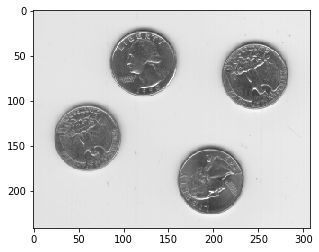

In [3]:
plt.imshow(img)

In [4]:
print(img[:,:,0])

[[225 225 225 ... 233 232 233]
 [225 225 225 ... 233 233 233]
 [226 226 225 ... 233 232 233]
 ...
 [225 226 225 ... 233 233 233]
 [226 226 225 ... 233 232 233]
 [226 226 226 ... 232 233 234]]


In [5]:
# Equivalent de roipoly ?

mask = np.zeros(img.shape[:2],dtype = 'uint8')

c = [194, 253, 293, 245]
r = [72, 14, 76, 125]

rc = np.array((c,r)).T

cv.drawContours(mask,[rc],0,255,-1)
cv.drawContours(img,[rc],0,255,2)
mask = cv.cvtColor(mask,cv.COLOR_GRAY2BGR)

res = np.hstack((img,mask))

resolution =  (242, 308, 3)


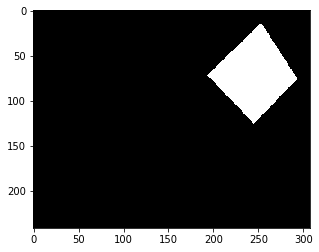

In [6]:
plt.imshow(mask)
print("resolution = ", np.shape(mask))

### Initialisation de la fonction phi : l'algorithme de Fast-Marching

Scikit-fmm.distance permet de calculer la distance signée entre chaque point de l'image et le bord du masque : positif à l'intérieur, négatif à l'extérieur.

In [7]:
mask = skfmm.distance(mask)

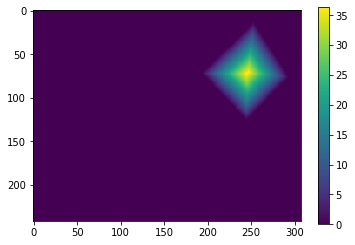

In [8]:
phi0 = mask
plt.imshow(phi0[:,:,1])
plt.colorbar()

### Chan Vese algorithm

In [9]:
# 4 - fonction Heaviside-Eta

In [10]:
def Heaviside_eta(phi,eta):
    M = (1 + 2. * np.arctan(phi/eta) / np.pi) / 2.
    return M

In [11]:
# 5 - delta-eta, gradx, grady, div 

In [12]:
def delta_eta(phi,eta):
    M = 1. / ((1 + (phi / eta)**2) * eta * np.pi)
    return M

In [13]:
def GradientHor(x):
    y=x-np.roll(x,1,axis=1)
    y[:,0]=0
    return y
def GradientVer(x):
    y=x-np.roll(x,1,axis=0)
    y[0,:]=0
    return y
def Gradient(x):
    y=[]
    y.append(GradientHor(x))
    y.append(GradientVer(x))
    return np.array(y)

In [14]:
def DivHor(x):
    N=len(x[0])
    y=x-np.roll(x,-1,axis=1)
    y[:,0]=-x[:,1]
    y[:,N-1]=x[:,N-1]
    return y
def DivVer(x):
    N=len(x)
    y=x-np.roll(x,-1,axis=0)
    y[0,:]=-x[1,:]
    y[N-1,:]=x[N-1,:]
    return y
def Div(y):
    x=DivHor(y[0])+DivVer(y[1])
    return x

In [15]:
np.sum(img)

43990875

In [16]:
c1 = 50
c2 = 200
tau = 1
lbda = 1
eta = 0.5

niter = 100
phi = phi0

In [29]:
def ChanVese(niter, phi, eta, img, c1, c2, tau):
    print("Iterations in progress ...")
    for i in range(niter):
        Hk = Heaviside_eta(phi,eta)
        deltak = delta_eta(phi,eta)
        gradphi = Gradient(phi)

        c1 = np.sum(img*Hk)/np.sum(Hk)
        c2 = np.sum(img*(1-Hk))/np.sum(1-Hk)

        phi += tau * deltak * ( Div(gradphi/npl.norm(gradphi)) - lbda * (img - c1)**2 + lbda * (img - c2)**2) 
        phi = skfmm.distance(phi)
    print("Done.")
    return phi, eta

In [30]:
def Fast_ChanVese(niter, phi, eta, img, c1, c2):
    print("Iterations in progress ...")
    for i in range(niter):
        Hk = Heaviside_eta(phi,eta)
        deltak = delta_eta(phi,eta)
        gradphi = Gradient(phi)

        c1 = np.sum(img*Hk)/np.sum(Hk)
        c2 = np.sum(img*(1-Hk))/np.sum(1-Hk)

        tau_k = deltak * (Div(gradphi/npl.norm(gradphi)) - lbda * (img - c1)**2 + lbda * (img - c2)**2)
        tau_k = np.max(np.abs(tau_k))

        phi += tau_k * deltak * ( Div(gradphi/npl.norm(gradphi)) - lbda * (img - c1)**2 + lbda * (img - c2)**2) 
        phi = skfmm.distance(phi)
    print("Done.")
    return phi, eta

In [31]:
phi_res, eta_res = Fast_ChanVese(niter, phi, eta, img, c1,c2)

Iterations in progress ...
Done.


In [32]:
u = Heaviside_eta(phi_res, eta_res)

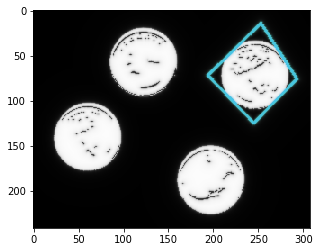

In [33]:
plt.imshow(u)

In [34]:
phi_ch, eta_ch = ChanVese(niter, phi, eta, img, c1, c2, tau)

Iterations in progress ...
Done.


In [35]:
u_ch = Heaviside_eta(phi_ch, eta_ch)

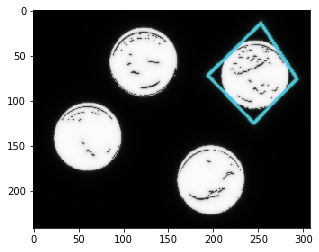

In [36]:
plt.imshow(u_ch)

In [43]:
kernel = np.ones((5,5),np.uint8)
u_ch = cv.dilate(u_ch, kernel, 1)
u_ch = cv.erode(u_ch, kernel, 1)

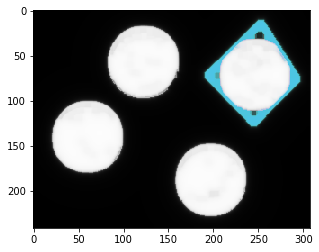

In [44]:
plt.imshow(u_ch)

## 3 - Chan, Esedoglu and Nikolova convex formulation

In [ ]:
c1 = 110
c2 = 227

